In [30]:
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from function_utils import *
from imblearn.over_sampling import SMOTE

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [45]:
def features_importance(X, model):
    features_names = X.columns
    d = {features_names[idx] :  model.feature_importances_[idx] for idx, val in enumerate(model.feature_importances_)}
    df = pd.DataFrame(d.items(), columns=['feature', 'value'])

    df["abs_value"] = df["value"].apply(lambda x: abs(x))
    df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
    df = df.sort_values("abs_value", ascending=False)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    fig = sns.barplot(x="feature",
                y="value",
                data=df.head(20),
               palette=df.head(20)["colors"])
    fig = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    fig = ax.set_title("Feature importance", fontsize=25)
    fig = ax.set_ylabel("Coef", fontsize=22)
    fig = ax.set_xlabel("Feature Name", fontsize=22)

# 1. preprocessing

In [2]:
app_train, app_test = Preprocessing().run()

# 2. Preparer les données

In [81]:
import re
app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app_test = app_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

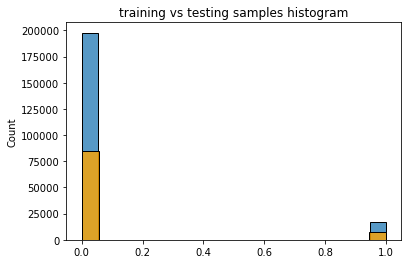

In [4]:
X = app_train.drop(columns = ['TARGET'])
y = app_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

plt.title("training vs testing samples histogram")
sns.histplot(y_train.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
train_data_for_neighbors = X_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)
train_target = y_train
test_data_for_neighbors = X_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)

knn = KNeighborsClassifier(500, n_jobs = -1)
knn.fit(train_data_for_neighbors, train_target)
train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

#adding the means of targets of 500 neighbors to new column
X_train['TARGET_NEIGHBORS_500_MEAN'] = [y_train.iloc[ele].mean() for ele in train_500_neighbors]
X_test['TARGET_NEIGHBORS_500_MEAN'] = [y_train.iloc[ele].mean() for ele in test_500_neighbors]

In [6]:
train_data_for_neighbors = X[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)
train_target = y

knn.fit(train_data_for_neighbors, train_target)
train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]

#adding the means of targets of 500 neighbors to new column
X['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in train_500_neighbors]

In [7]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X = X.fillna(0)

# 3. Model

In [8]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=3)
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

## 3.1 Model raw data

### 3.1.1 Random Forest

In [9]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1, class_weight = 'balanced')
scores = cross_val_score(rf, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.00223674, 0.00156593, 0.00268426, 0.0031315 , 0.00447267])

[+] fbeta score : 0.49695328154984425
[+] roc score : 0.5011399065911297


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


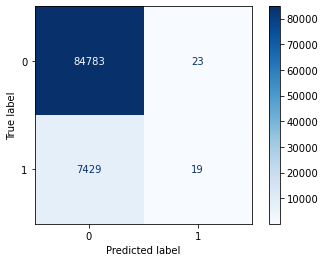

In [9]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1, class_weight = 'balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

results(rf, X_test, y_test, y_pred)

### 3.1.2 Xgboost

In [12]:
clf  = XGBClassifier(scale_pos_weight=3)
scores = cross_val_score(clf, X, y, cv=kfold, scoring=ftwo_scorer)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.5958303432958045
[+] roc score : 0.5933634374029583


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


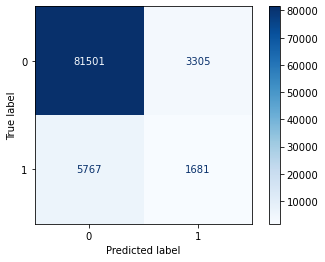

In [11]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

### 3.1.3 LGB

In [13]:
lgb = LGBMClassifier(random_state=100, n_jobs=-1, class_weight = 'balanced')
scores = cross_val_score(lgb, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.53388507, 0.54624079, 0.53769315, 0.52836162, 0.54059966])

[+] fbeta score : 0.6356254707449758
[+] roc score : 0.7024230895798493


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


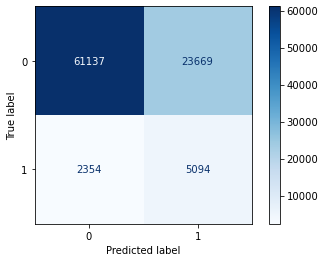

In [14]:
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

## 3.2. Model Under Sampling

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

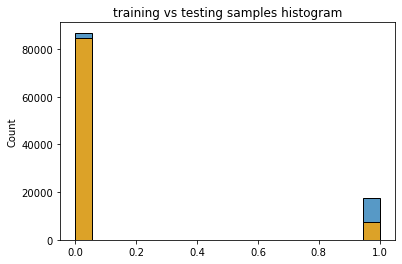

In [15]:
undersample = NearMiss(version=1, n_neighbors=4, sampling_strategy=0.2)

X_train_u, y_train_u = undersample.fit_resample(X_train, y_train)

plt.title("training vs testing samples histogram")
sns.histplot(y_train_u.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

### 3.2.1 Random 

In [16]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1)
scores = cross_val_score(rf, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.00134243, 0.00111867, 0.00178983, 0.00111874, 0.00134243])

[+] fbeta score : 0.49688575528759693
[+] roc score : 0.5162678343797139


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


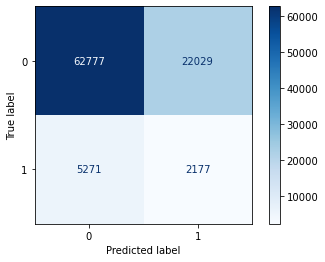

In [17]:
rf.fit(X_train_u, y_train_u)
y_pred = rf.predict(X_test)

results(rf, X_test, y_test, y_pred)

### 3.2.2 Xgboost

In [18]:
clf  = XGBClassifier()
scores = cross_val_score(clf, X, y, cv=kfold, scoring=ftwo_scorer)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.49016541282661236
[+] roc score : 0.5337117972141534


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


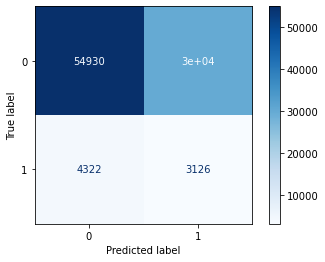

In [21]:
clf.fit(X_train_u, y_train_u)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

### 3.2.3 LGB

In [22]:
lgb = LGBMClassifier(random_state=100, n_jobs=-1)
scores = cross_val_score(lgb, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.53388507, 0.54624079, 0.53769315, 0.52836162, 0.54059966])

[+] fbeta score : 0.47537591108532795
[+] roc score : 0.593339966572598


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


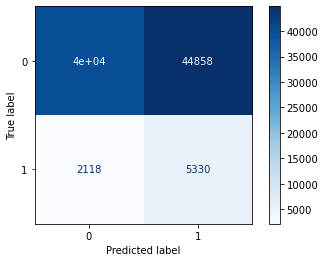

In [24]:
lgb.fit(X_train_u, y_train_u)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

## 3.3. Model with over and under sampling

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

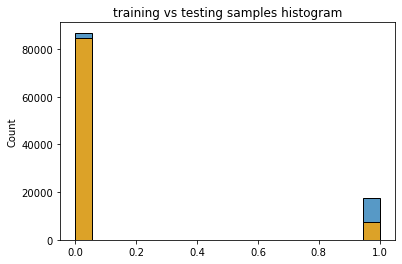

In [29]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_u_o, y_train_u_o = oversample.fit_resample(X_train_u, y_train_u)


plt.title("training vs testing samples histogram")
sns.histplot(y_train_u.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

### 3.3.1 Random Forest

[+] fbeta score : 0.47537591108532795
[+] roc score : 0.593339966572598


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


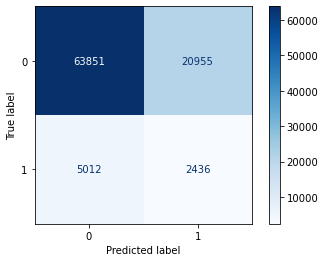

In [26]:
rf.fit(X_train_u_o, y_train_u_o)
y_pred = lgb.predict(X_test)

results(rf, X_test, y_test, y_pred)

### 3.3.2 Xgboost

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.4865516691929213
[+] roc score : 0.5877293203825308


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


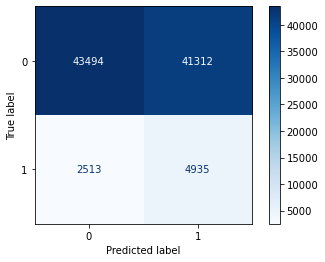

In [27]:
clf.fit(X_train_u_o, y_train_u_o)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

In [ ]:
features_names = app_train.drop(columns = ['TARGET']).columns
d = {features_names[idx] :  lgb.feature_importances_[idx] for idx, val in enumerate(lgb.feature_importances_)}
df = pd.DataFrame(d.items(), columns=['feature', 'value'])

df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
fig = sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
fig = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
fig = ax.set_title("Feature importance", fontsize=25)
fig = ax.set_ylabel("Coef", fontsize=22)
fig = ax.set_xlabel("Feature Name", fontsize=22)

### 3.3.3 LGB

[+] fbeta score : 0.47451113692853997
[+] roc score : 0.5898665084926378


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


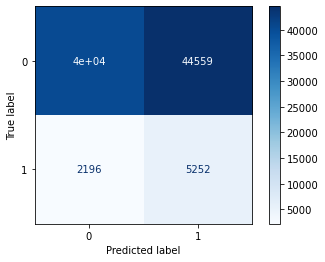

In [28]:
lgb.fit(X_train_u_o, y_train_u_o)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

## 3.4 Model with oversampling
### 3.4.1 SMOTE

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

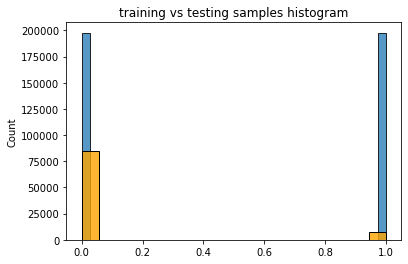

In [34]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

plt.title("training vs testing samples histogram")
sns.histplot(y_train_smote.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.5234459161368639
[+] roc score : 0.5245391481481472


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


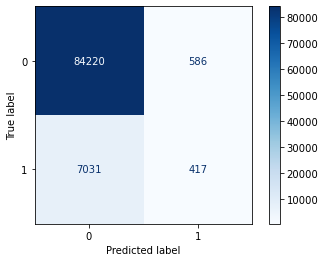

In [43]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

[+] fbeta score : 0.5086272318157238
[+] roc score : 0.5114489111472541


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


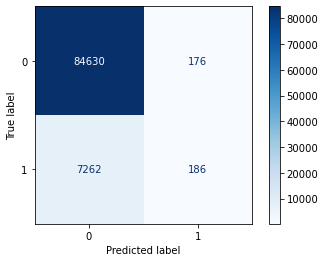

In [35]:
lgb.fit(X_train_smote, y_train_smote)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

### 3.4.2 RandomOverSampler

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

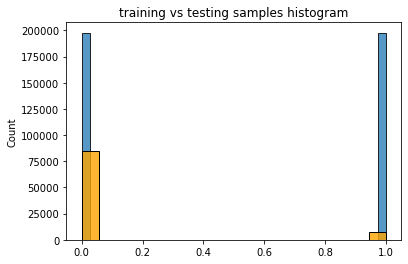

In [36]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)

plt.title("training vs testing samples histogram")
sns.histplot(y_train_o.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.6383123933791743
[+] roc score : 0.6857238399650147


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


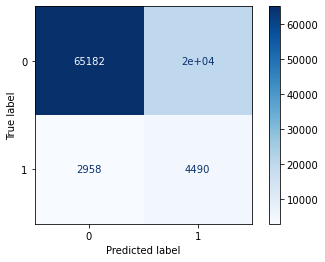

In [44]:
clf.fit(X_train_o, y_train_o)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

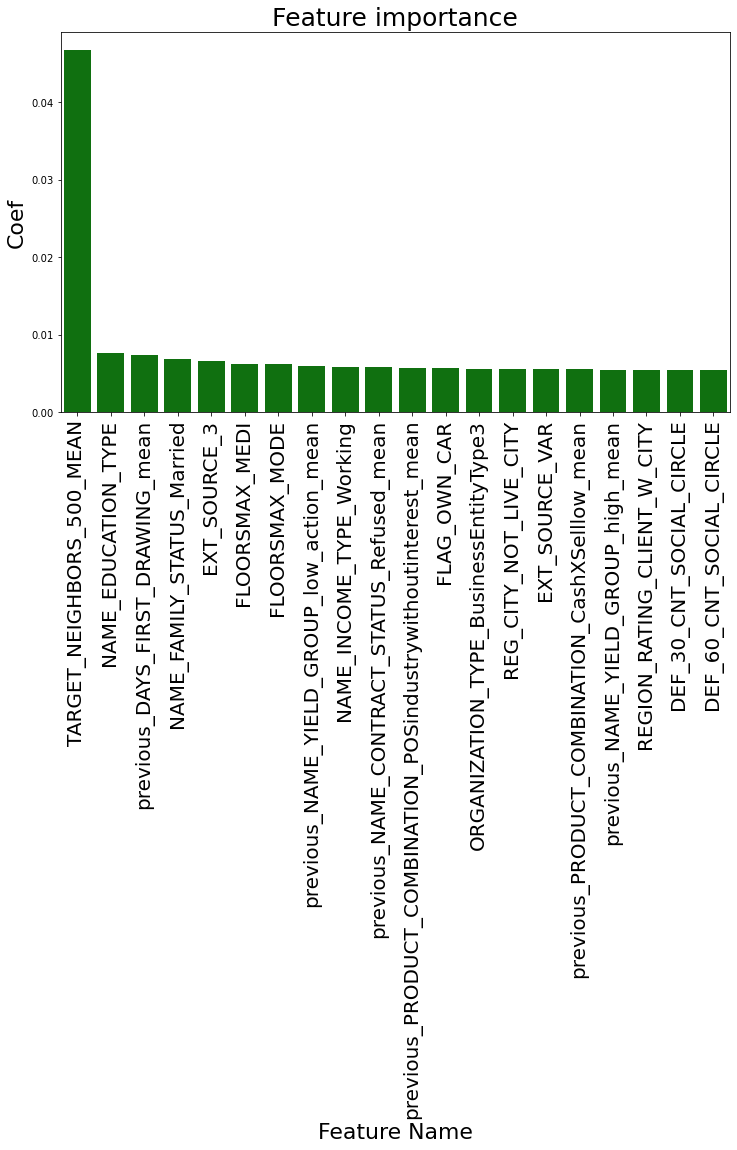

In [46]:
features_importance(X, clf)

[+] fbeta score : 0.6360248720749848
[+] roc score : 0.7021603191873343


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


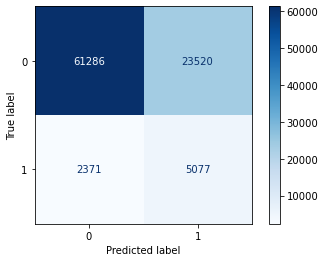

In [38]:
lgb.fit(X_train_o, y_train_o)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

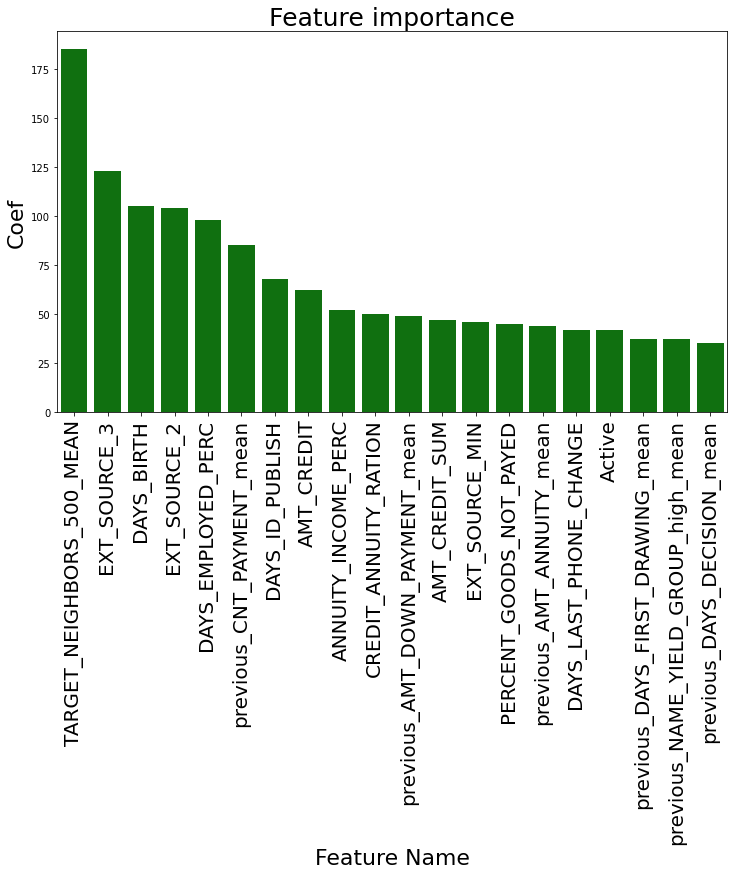

In [47]:
features_importance(X, lgb)

# 4. Tuning des parametres

### 4.1. Xgboost

In [48]:
class TuningRegressor_XGB:
    def __init__(self, search_space=None, random_state=42): 
        self.search_space = search_space
        self.random_state = random_state

    def hyperparameter_tuning(self, space):
        print(space['max_depth'])
        model=XGBClassifier(
                    n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
        model.fit(X_train_o, y_train_o)

        y_pred = model.predict(X_test)
        fbeta = fbeta_score(y_test, y_pred, average='macro', beta=3)
        return {'loss': -fbeta, 'status': STATUS_OK, 'model': model}

    def optimisation(self):
        best_params= {}
        if self.search_space : 
            trials = Trials()
            best_params = fmin(fn=self.hyperparameter_tuning,
                                space=self.search_space,
                                algo=tpe.suggest,
                                max_evals=10,
                                trials=trials, 
                                verbose=1)
            best_params = space_eval(self.search_space, best_params)
            fnvals = [t['result']['loss'] for t in trials.trials]
            best_loss = min(fnvals)
            
        return best_params, best_loss

In [49]:
space={
    'max_depth': hp.quniform("max_depth", 1, 20, 1),
    'gamma': hp.uniform('gamma', 1, 12),
    'reg_alpha' : hp.quniform('reg_alpha', 40, 200, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'booster':hp.choice("booster", ["gbtree", "dart"]),
    'objective':hp.choice("objective", ['reg:squaredlogerror', 'reg:squarederror']), 
    'n_estimators': hp.choice('n_estimators', range(100, 200, 10)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01 )
}

best_params, best_loss = TuningRegressor_XGB(search_space=space).optimisation()

2.0                                                                                                                    
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5.0                                                                                                                    
 10%|████▊                                           | 1/10 [00:07<01:08,  7.60s/trial, best loss: -0.5591540143918404]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2.0                                                                                                                    
 20%|█████████▌                                      | 2/10 [00:15<01:02,  7.81s/trial, best loss: -0.5773559648219965]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6.0                                                                                                                    
 30%|██████████████▍                                 | 3/10 [00:25<01:02,  8.97s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9.0                                                                                                                    
 40%|███████████████████▏                            | 4/10 [00:35<00:55,  9.17s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
14.0                                                                                                                   
 50%|████████████████████████                        | 5/10 [00:47<00:50, 10.12s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4.0                                                                                                                    
 60%|████████████████████████████▊                   | 6/10 [00:56<00:39,  9.92s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2.0                                                                                                                    
 70%|█████████████████████████████████▌              | 7/10 [01:06<00:29,  9.78s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
20.0                                                                                                                   
 80%|██████████████████████████████████████▍         | 8/10 [01:14<00:18,  9.28s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:19:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
7.0                                                                                                                    
 90%|███████████████████████████████████████████▏    | 9/10 [01:26<00:10, 10.04s/trial, best loss: -0.6012998052733698]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
100%|███████████████████████████████████████████████| 10/10 [01:40<00:00, 10.02s/trial, best loss: -0.6035004829192188]


### 4.2 LGB

In [74]:
class TuningRegressor_LGB:
    def __init__(self, search_space=None, random_state=42): 
        self.search_space = search_space
        self.random_state = random_state

    def hyperparameter_tuning(self, space):
        model = LGBMClassifier(
            num_leaves=int(space['num_leaves']),
            max_bin=int(space['max_bin']),
            min_child_samples=int(space['min_child_samples']),
            n_estimators=int(space['n_estimators']),
            reg_alpha=int(space['reg_alpha']),
            reg_lambda=int(space['reg_lambda'])
        )
        model.fit(X_train_o, y_train_o)

        y_pred = model.predict(X_test)
        fbeta = fbeta_score(y_test, y_pred, average='macro', beta=3)
        return {'loss': -fbeta, 'status': STATUS_OK, 'model': model}

    def optimisation(self):
        best_params= {}
        if self.search_space : 
            trials = Trials()
            best_params = fmin(fn=self.hyperparameter_tuning,
                                space=self.search_space,
                                algo=tpe.suggest,
                                max_evals=30,
                                trials=trials, 
                                verbose=1)
            best_params = space_eval(self.search_space, best_params)
            fnvals = [t['result']['loss'] for t in trials.trials]
            best_loss = min(fnvals)
            
        return best_params, best_loss

In [75]:
space={
    'num_leaves': hp.quniform("num_leaves", 10, 100, 10),
    'max_bin' : hp.quniform('max_bin', 500, 1500, 500),
    'min_child_samples' : hp.quniform('min_child_samples', 500, 1000, 10),
    'n_estimators': hp.choice('n_estimators', range(50, 300, 10)),
    'reg_alpha': hp.quniform('reg_alpha', 0.01, 0.5, 0.01 ),
    'reg_lambda': hp.quniform('reg_lambda', 0.01, 0.5, 0.01 )
}

best_params, best_loss = TuningRegressor_LGB(search_space=space).optimisation()

100%|███████████████████████████████████████████████| 30/30 [09:31<00:00, 19.06s/trial, best loss: -0.6554259941073712]


# 5. Save best model

In [72]:
X_o, y_o = oversample.fit_resample(X, y)

lgb = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_bin=int(best_params['max_bin']),
    min_child_samples=int(best_params['min_child_samples']),
    n_estimators=int(best_params['n_estimators']),
    reg_alpha=int(best_params['reg_alpha']),
    reg_lambda=int(best_params['reg_lambda'])
)

scores = cross_val_score(lgb, X_o, y_o, cv=kfold, scoring=ftwo_scorer)
scores

array([0.8708009 , 0.87014402, 0.87031567, 0.87030175, 0.86823165])

In [73]:
model = lgb.fit(X_o, y_o)

In [80]:
import joblib
# save model
joblib.dump(model, 'lgb.pkl')

['lgb.pkl']

In [82]:
train_data_for_neighbors = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)
train_target = y
test_data_for_neighbors = app_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)

knn = KNeighborsClassifier(500, n_jobs = -1)
knn.fit(train_data_for_neighbors, train_target)
train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

#adding the means of targets of 500 neighbors to new column
app_train['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in train_500_neighbors]
app_test['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in test_500_neighbors]

In [83]:
app_test = app_test.fillna(0)

In [90]:
app_test.to_csv('clients_data.csv', index=False)

In [91]:
app_test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'NAME_EDUCATION_TYPE', 'REGION_POPULATION_RELATIVE',
       ...
       'previous_CNT_PAYMENT_mean', 'previous_HOUR_APPR_PROCESS_START_mean',
       'previous_SELLERPLACE_AREA_mean', 'previous_AMT_DOWN_PAYMENT_mean',
       'previous_AMT_ANNUITY_mean', 'previous_AMT_CREDIT_mean',
       'previous_AMT_APPLICATION_mean', 'previous_AMT_GOODS_PRICE_mean',
       'previous_DAYS_FIRST_DRAWING_mean', 'TARGET_NEIGHBORS_500_MEAN'],
      dtype='object', length=355)

In [92]:
0['SK_ID_CURR']

0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64

In [94]:
data_client = app_test[app_test.SK_ID_CURR == 100001]

In [95]:
data_client

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,previous_CNT_PAYMENT_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_ANNUITY_mean,previous_AMT_CREDIT_mean,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_DAYS_FIRST_DRAWING_mean,TARGET_NEIGHBORS_500_MEAN
0,100001,0,0,1,0,135000.0,568800.0,450000.0,2,0.01885,...,8.0,13.0,23.0,2520.0,3951.0,23787.0,24835.5,24835.5,365243.0,0.034


In [117]:
data = pd.read_csv('data/model/clients_data.csv')

In [129]:
data[data.SK_ID_CURR == 100001].index

Int64Index([0], dtype='int64')

In [130]:
data.iloc[data[data.SK_ID_CURR == 100001].index]

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,previous_CNT_PAYMENT_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_ANNUITY_mean,previous_AMT_CREDIT_mean,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_DAYS_FIRST_DRAWING_mean,TARGET_NEIGHBORS_500_MEAN
0,100001,0,0,1,0,135000.0,568800.0,450000.0,2,0.01885,...,8.0,13.0,23.0,2520.0,3951.0,23787.0,24835.5,24835.5,365243.0,0.034


In [98]:
clients = pd.read_csv('data/application_test.csv')

In [104]:
clients.columns[0:60]

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG'

In [111]:
model.predict_proba

<bound method LGBMClassifier.predict_proba of LGBMClassifier(max_bin=1000, min_child_samples=840, n_estimators=230,
               num_leaves=90, reg_alpha=0, reg_lambda=0)>

In [115]:
from lime import lime_tabular

In [123]:
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(data),
    feature_names = data.columns,
    class_names=['payed', 'did not payed' ],
    mode='classification')

In [122]:
data_ex

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,previous_CNT_PAYMENT_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_ANNUITY_mean,previous_AMT_CREDIT_mean,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_DAYS_FIRST_DRAWING_mean,TARGET_NEIGHBORS_500_MEAN
0,100001,0,0,1,0,135000.0,568800.0,450000.0,2,0.01885,...,8.0,13.0,23.0,2520.0,3951.0,23787.0,24835.5,24835.5,365243.0,0.034


In [138]:
data[data.SK_ID_CURR == 100001].index.values[0]

0

In [137]:
lime_exp = lime_explainer.explain_instance(
    data_row=data.iloc[data[data.SK_ID_CURR == 100005].index.values[0]],
    predict_fn=model.predict_proba
)

In [121]:
exp = explainer.explain_instance(data_ex, model.predict_proba, num_features=6)

TypeError: '(slice(None, None, None), 0)' is an invalid key